<a href="https://colab.research.google.com/github/Anjalsanand/CSS-animation-/blob/master/Swin_transformer_fine_tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Code is based on https://www.learnpytorch.io/08_pytorch_paper_replicating/ documentation

importing a pretrained swin transformer from pytorch documentation and fine tuning it



In [ ]:
# @title import torch modules of required version

# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121


In [ ]:
# @title impoting helper funtions fron github

# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from pathlib import Path

image_path = Path("/content/drive/MyDrive/S8_Main_Project/Binary_2k.zip")
image_path

PosixPath('/content/drive/MyDrive/S8_Main_Project/Binary_2k.zip')

In [ ]:
# # just for reference not part of this project
# from datasets import load_dataset
# dataset = load_dataset("imagefolder", data_files="/content/drive/MyDrive/S8_Main_Project/Binary_2k.zip")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
#unzippig dataset zip file
import zipfile
with zipfile.ZipFile(image_path, 'r') as zip_ref:
    zip_ref.extractall('/content/Binary_2k')

# !unzip {image_path} -d /content/binary_datset_2k (an alternative method, but print all Image path during executuin)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = torchvision.datasets.ImageFolder(root="/content/binary_datset_2k", transform=transform)
len(dataset)

2073

In [ ]:

# Split the dataset into training and test sets
train_split=int(len(dataset)*0.85)
test_split=int(len(dataset)-train_split)
print(train_split, test_split)
train_set, test_set = torch.utils.data.random_split(dataset, [train_split, test_split])

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
print(len(train_loader), len(test_loader))


1762 311
56 10


In [ ]:
image_batch, label_batch = next(iter(train_loader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

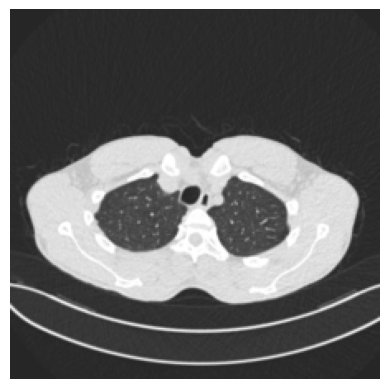

In [ ]:
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.axis(False);

## **Vit Fine Tuning**

In [ ]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class_names=['Cancer', 'Normal']

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
dataset = torchvision.datasets.ImageFolder(root="/content/binary_datset_2k", transform=pretrained_vit_transforms)
print(len(dataset))
train_set, test_set = torch.utils.data.random_split(dataset, [train_split, test_split])

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
print(len(train_loader), len(test_loader))

2073
56 10


In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_loader,
                                      test_dataloader=test_loader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0240 | train_acc: 0.9989 | test_loss: 0.0005 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.0004 | train_acc: 1.0000 | test_loss: 0.0004 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0003 | train_acc: 1.0000 | test_loss: 0.0003 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0003 | train_acc: 1.0000 | test_loss: 0.0002 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 0.0002 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 0.0002 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 0.0001 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 0.0001 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 0.0001 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 0.0001 | test_acc: 1.0000
